## <center> Krutika Ambavane </center>

### <center> Prediction of whether an apartment will be in SF or not using Logistic Regression </center>

#### Importing required libraries

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline
import sklearn as sk
import sklearn.tree as tree
import seaborn as sns
from IPython.display import Image  
import pydotplus
import plotly.plotly as py
from plotly.graph_objs import *
pd.set_option('display.max_columns', None)
pd.set_option('precision', 2)
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from collections import Counter
import itertools
import matplotlib.ticker as tick
import matplotlib.patches as patches
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as pyplt
% matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [55]:
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

 #### Reading the file

In [56]:
df = pd.read_csv("ny_sf_apt.csv", encoding = 'latin-1')

In [57]:
df.head(2)

,in_sf,beds,bath,price,year_built,sqft,price_per_sqft,elevation
0,0,2.0,1.0,999000,1960,1000,999,10
1,0,2.0,2.0,2750000,2006,1418,1939,0


In [58]:
df.shape 

(492, 8)

In [59]:
df.in_sf.unique() #our response column

array([0, 1])

#### Checking for null values:

In [60]:
df.isna().any()

in_sf             False
beds              False
bath              False
price             False
year_built        False
sqft              False
price_per_sqft    False
elevation         False
dtype: bool

#### Selecting a single best feature to start with:

#### Feature selection using correlation:

In [61]:
df.corr()

,in_sf,beds,bath,price,year_built,sqft,price_per_sqft,elevation
in_sf,1.00,0.30,0.07,-0.25,-0.14,0.11,-0.54,0.54
beds,0.30,1.00,0.83,0.44,-0.07,0.79,0.04,0.32
bath,0.07,0.83,1.00,0.62,0.07,0.85,0.27,0.11
price,-0.25,0.44,0.62,1.00,0.19,0.72,0.77,-0.14
year_built,-0.14,-0.07,0.07,0.19,1.00,-0.04,0.39,-0.21
sqft,0.11,0.79,0.85,0.72,-0.04,1.00,0.27,0.17
price_per_sqft,-0.54,0.04,0.27,0.77,0.39,0.27,1.00,-0.37
elevation,0.54,0.32,0.11,-0.14,-0.21,0.17,-0.37,1.00


In [62]:
df.corr()['in_sf'].sort_values(ascending=False)

in_sf             1.00
elevation         0.54
beds              0.30
sqft              0.11
bath              0.07
year_built       -0.14
price            -0.25
price_per_sqft   -0.54
Name: in_sf, dtype: float64

#### <div class="alert alert-block alert-success"> Elevation has highest correlation with our response variable (in_sf). So our single best feature would be elevation for now.

In [63]:
df['ele_bins'] = pd.cut(df.elevation, bins=15,include_lowest=True)

In [64]:
sns.set_context("talk")
sns.set_style("whitegrid", {'grid.color': '.92'})

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)

    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")

    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]

    return new_tick_format

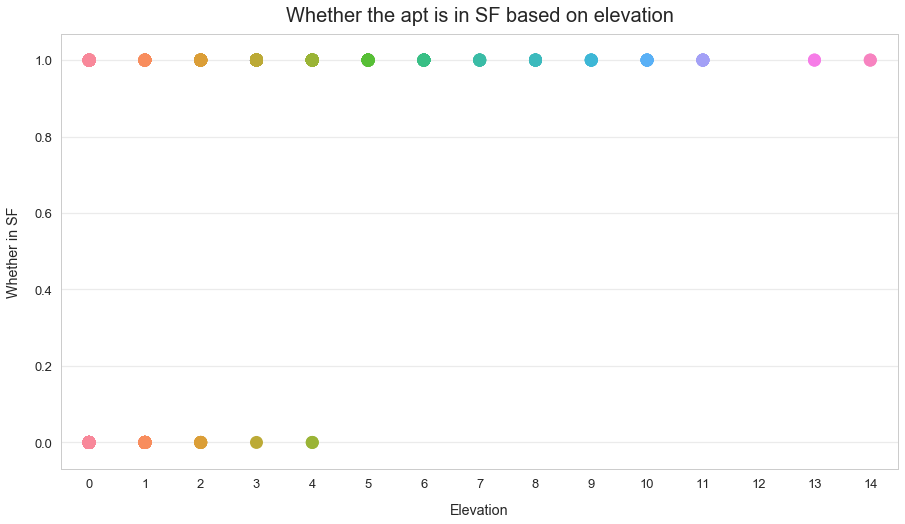

In [65]:
plt.figure(figsize=(15, 8))
sns.stripplot(data=df, x="ele_bins", y="in_sf", jitter=False, size=13)
plt.xlabel("Elevation", labelpad=13)
plt.ylabel("Whether in SF", labelpad=13)
plt.title("Whether the apt is in SF based on elevation", y=1.015, fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

Text(0.5,0,'elevation bins')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

Text(0,0.5,'in sf')

Text(0.5,1,'elevation vs in_sf')

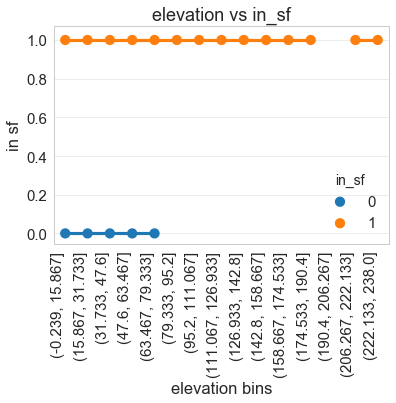

In [66]:
sns.set_context("notebook", font_scale=1.5)
sns.pointplot(x='ele_bins',y='in_sf',hue='in_sf',data=df,aspect = 5)
pyplt.xlabel('elevation bins')
pyplt.xticks(rotation=90, ha='right')
pyplt.ylabel('in sf')
pyplt.title('elevation vs in_sf')
#pyplt.show(fig);

<div class="alert alert-block alert-success"><b>Upon looking at this graph, I think we can divide the data into two classes at elevation of 73m. So above 73m houses can be classified as the ones in SF. Below 73m, the houses will be in NY. <br>However, we will have some false negatives here. That is accepted for now beacuse we are taking into consideration just one feature at this point.

___

### <div class="alert alert-block alert-info"> Performing Logistic Regression: </div>

#### Model with one feature: 'elevation'

#### Model fitting and prediction of whether the house will be in SF or not, using elevation:

In [67]:
X = df['elevation'].values.reshape(-1, 1)
Y = df['in_sf'].values

In [68]:
scaler = StandardScaler()
scaler.fit(X)
X_transformed = scaler.transform(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

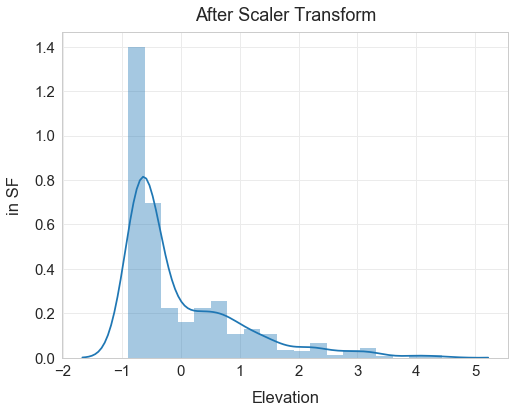

In [69]:
plt.figure(figsize=(8, 6))
x = X_transformed
sns.distplot(X_transformed)
plt.title("After Scaler Transform", y=1.015)
plt.xlabel("Elevation", labelpad=12)
plt.ylabel("in SF", labelpad=12);

In [70]:
x_train, x_test, y_train, y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state=20)

In [71]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [72]:
log_reg.predict_proba(x_train)[0]

array([0.08, 0.92])

In [74]:
log_reg.predict_proba(x_train)[1].mean()

0.5

#### <div class="alert alert-block alert-success">This shows that cutoff from your model is indeed the 50% threshold for probability.

In [75]:
log_reg.score(x_train,y_train)

0.7888040712468194

In [76]:
X_train_probability_class_1 = log_reg.predict_proba(x_train)[:, 1]
X_train_probability_class_1[0]

0.9170413208320641

In [77]:
predictions = {"x_train_points": x_train.flatten(),
                 "x_train_probability_being_class_1": X_train_probability_class_1}
df_predictions = pd.DataFrame(predictions)

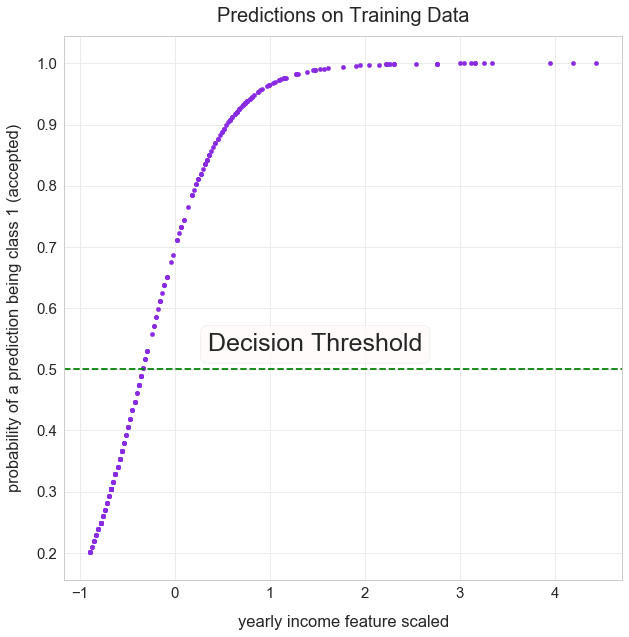

In [78]:
ax = df_predictions.plot.scatter(x="x_train_points", y="x_train_probability_being_class_1", figsize=(10, 10), c='blueviolet')
plt.title("Predictions on Training Data", y=1.015, fontsize=20)
plt.xlabel("yearly income feature scaled", labelpad=14)
plt.ylabel("probability of a prediction being class 1 (accepted)", labelpad=14)
plt.axhline(y=0.5, linestyle="--", color='green')
bbox_props_decision_threshold = dict(boxstyle="round", fc="snow", ec="0.8", alpha=0.8)
ax.text(0.35, 0.53, "Decision Threshold", bbox=bbox_props_decision_threshold, size=25);

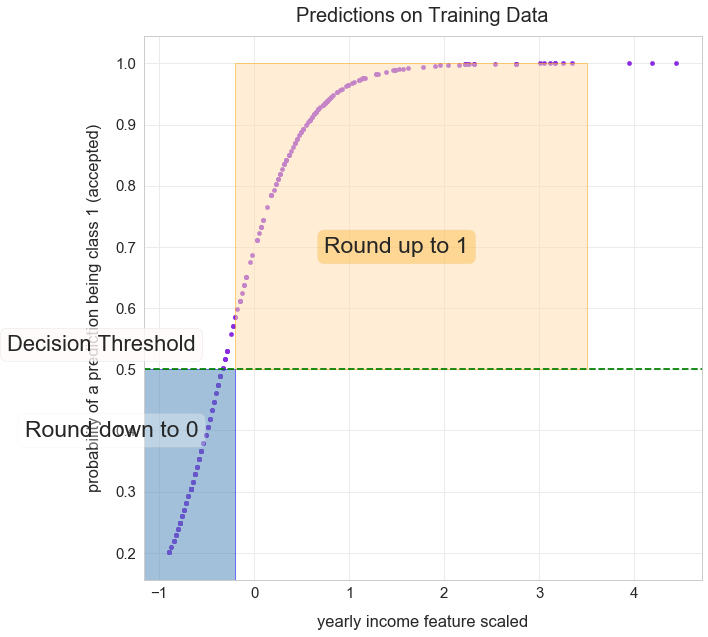

In [79]:
ax = df_predictions.plot.scatter(x="x_train_points", y="x_train_probability_being_class_1", figsize=(10, 10), c='blueviolet')
plt.title("Predictions on Training Data", y=1.015, fontsize=20)
plt.xlabel("yearly income feature scaled", labelpad=14)
plt.ylabel("probability of a prediction being class 1 (accepted)", labelpad=14)
plt.axhline(y=0.5, linestyle="--", color='green')
bbox_props_decision_threshold = dict(boxstyle="round", fc="snow", ec="0.8", alpha=0.8)
ax.text(-2.60, 0.53, "Decision Threshold", bbox=bbox_props_decision_threshold, size=22);

orange_rect = patches.Rectangle((-0.2, 0.5), 3.7, 0.5, linewidth=1, edgecolor='orange', facecolor='navajowhite', alpha=0.5)
ax.add_patch(orange_rect)
bbox_props_approved = dict(boxstyle="round", fc="orange", ec="0.8", alpha=0.3)
ax.text(1.5, 0.7, "Round up to 1", ha="center", va="center", size=23, bbox=bbox_props_approved)

blue_rect = patches.Rectangle((-2.7, 0), 2.5, 0.5, linewidth=1, edgecolor='blue', facecolor='steelblue', alpha=0.5)
ax.add_patch(blue_rect)
bbox_props_denied = dict(boxstyle="round", fc="white", ec="0.8", alpha=0.3)
ax.text(-1.5, 0.4, "Round down to 0", ha="center", va="center", size=23, bbox=bbox_props_denied);

#### Lets see what the model predicted:

In [80]:
y_test_predictions = log_reg.predict(x_test)
y_test_predictions

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0])

#### Score of our model on test data:

In [81]:
log_reg.score(x_test, y_test)

0.8484848484848485

#### Plotting the confusion matrix:

In [82]:
class_names = ["IN NY", "IN SF"]

<Figure size 504x504 with 0 Axes>

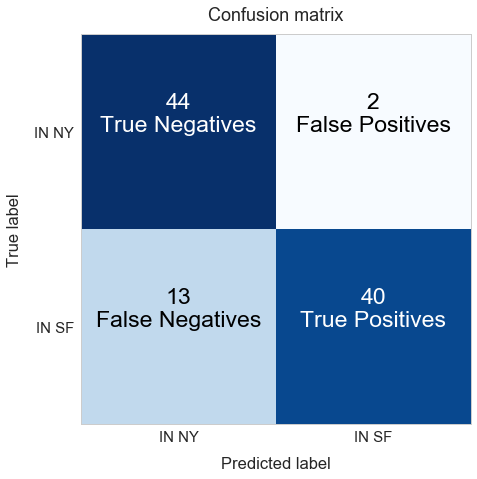

In [83]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    name = None    
    fmt = 'd'
    thresh = cm.max() / 2
    # i and j tell us the coordinates of boxes
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 0 and j == 0:
            name = "True Negatives"
        elif i == 0 and j == 1:
            name = "False Positives"
        elif i == 1 and j == 1:
            name = "True Positives"
        else:
            name = "False Negatives"
        plt.text(j, i, format(cm[i, j], fmt) + "\n" + name, horizontalalignment="center", 
                 fontsize=23, color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', labelpad=12)
    plt.xlabel('Predicted label', labelpad=12)
    plt.title(title, y=1.02)
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_predictions);
np.set_printoptions(precision=2);

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

<b>Interpretation from the matrix:</b> <br>There are two class labels: IN SF and IN NY.
The x-axis is labeled Predicted label- our model's predictions given X_test.
The y-axis is labeled True label- the class labels for our X_test observations.
The model made a total of 99 predictions (equivalent to 44+4+14+37) and if those predictions would be in SF or in NY.
Out of them, 15 predictions are wrong.

- For 44 observations (from X_test) the model predicted IN NY and the label was actually IN NY.
- For 13 observations (from X_test) the model predicted IN NY but the label was actually IN SF.
- For 40 observations (from X_test) the model predicted IN SF and the label was actually IN SF.
- For 2 observations (from X_test) the model predicted IN SF but the label was actually IN NY.

In [84]:
roc_auc_score = roc_auc_score(y_test, y_test_predictions)
print("ROC AUC: {0}".format(roc_auc_score))

ROC AUC: 0.8556193601312552


#### Lets see the predictions and the predicted probability on our test set:

In [85]:
log_reg.predict_proba(x_test)[0]

array([0.7, 0.3])

In [86]:
log_reg.predict_proba(x_test)[1].mean()

0.5

#### This shows that cutoff from your model is indeed the 50% threshold for probability.

In [87]:
y_test_probability_predictions = log_reg.predict_proba(x_test)[:, 1]

In [88]:
y_test_probability_predictions[0:3]

array([0.3 , 0.79, 0.3 ])

In [89]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_test_probability_predictions)

#### Plotting ROC curve:

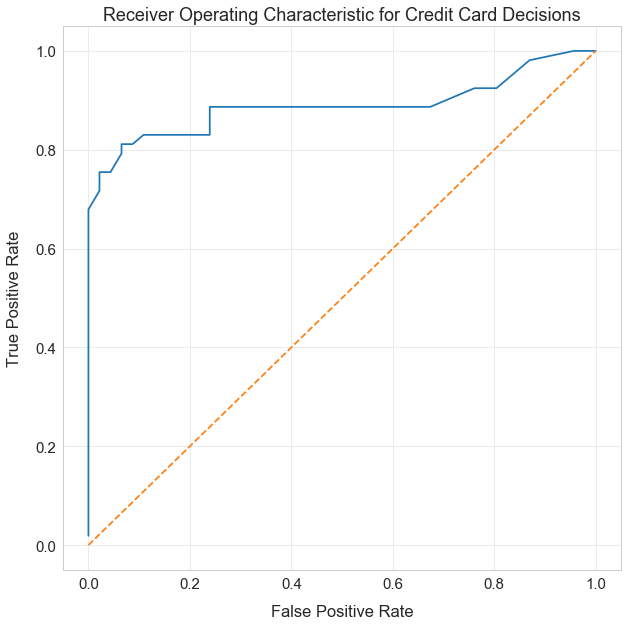

In [90]:

plt.figure(figsize=(10, 10))
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.title('Receiver Operating Characteristic for Credit Card Decisions')
plt.ylabel('True Positive Rate', labelpad=13)
plt.xlabel('False Positive Rate', labelpad=13);

In [91]:
print("Precision: {0}".format(precision_score(y_test, y_test_predictions)))

Precision: 0.9523809523809523


In [92]:
print("Recall:", round(recall_score(y_test, y_test_predictions), 2))

Recall: 0.75


___

#### <div class="alert alert-block alert-info"> Adding second feature to our model:

#### Model with 2 features: 'elevation' & 'price_per_sqft'

In [93]:
X2 = df[['elevation','price_per_sqft']]
Y2 = df['in_sf']

In [94]:
scaler = StandardScaler()
scaler.fit(X2)
X_transformed = scaler.transform(X2)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [95]:
x_train, x_test, y_train, y_test = train_test_split(X_transformed, Y2, test_size = 0.2, random_state=20)

In [96]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
log_reg.predict_proba(x_train)[0]

array([0.06, 0.94])

#### Score of our model on training data:

In [98]:
log_reg.score(x_train,y_train)

0.8015267175572519

#### Looking at our predictions:

In [99]:
y_test_predictions_2 = log_reg.predict(x_test)
y_test_predictions_2

array([0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1])

#### Score of our model on test data:

In [100]:
log_reg.score(x_test, y_test)

0.8181818181818182

#### Plotting confusion matrix:

<Figure size 504x504 with 0 Axes>

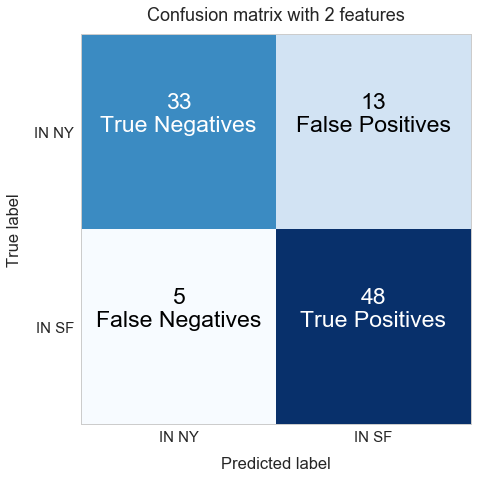

In [101]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_predictions_2);
np.set_printoptions(precision=2);

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix with 2 features')

#### This model gave wrong predictions for 18 apartments.

<div class="alert alert-block alert-success"> <b>The model with 2 features did not perform better than model with one feature. This can be concluded by seeing that the score of our model which decreased.

___

#### <div class="alert alert-block alert-info"> Adding third feature to our model:

#### Model with 3 features:

In [102]:
from sklearn import metrics, cross_validation

def cross_validate_method(x, y):
    scaler = StandardScaler()
    scaler.fit(x)
    X_transformed = scaler.transform(x)
    x_train, x_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.2, random_state=20)
    log_reg = LogisticRegression()
    log_reg.fit(x_train, y_train)

    print("predict proba             : " , log_reg.predict_proba(x_train)[0])
    print("score on training data    : ", log_reg.score(x_train,y_train))

    logreg = LogisticRegression()
    predicted = cross_validation.cross_val_predict(logreg, x_train, y_train, cv=10)
    print("cross_validation accuracy : ", metrics.accuracy_score(y_train, predicted))
    print(metrics.classification_report(y_train, predicted))

#### Using 'beds' as the third feature:

In [103]:
cross_validate_method(df[['elevation','price_per_sqft','beds']],  df['in_sf'])

predict proba             :  [0.03 0.97]
score on training data    :  0.8295165394402035
cross_validation accuracy :  0.8269720101781171
             precision    recall  f1-score   support

          0       0.80      0.83      0.81       178
          1       0.86      0.82      0.84       215

avg / total       0.83      0.83      0.83       393



#### Using 'price' as the third feature:

In [104]:
cross_validate_method(df[['elevation','price_per_sqft','price']],  df['in_sf'])

predict proba             :  [0.06 0.94]
score on training data    :  0.8091603053435115
cross_validation accuracy :  0.7989821882951654
             precision    recall  f1-score   support

          0       0.77      0.80      0.78       178
          1       0.83      0.80      0.81       215

avg / total       0.80      0.80      0.80       393



<b>The R-squared value decreased. There is no significant change.
    
<div class="alert alert-block alert-success"> <b>Thus, we choose the first model. We can also say that Elevation feature performs best on test data as well.